miniGAP (in repository)  
currently compartmentalizing this into multiple notebooks

In [16]:
# Import everything immediately
# This looks messy right now. I can sort it by type of packages later
import sys
sys.path.append('../code')
from Molecular_Dynamics import generate_md_traj
from Generate_Descriptors import get_dscribe_descriptors

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfk = tfp.math.psd_kernels
from itertools import islice
from  tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
from ase.io import read

In [6]:


if False:
    from miniGAP_functions import LearnEnergyFromSoap, LearnFromSoap

    import matplotlib
    import numpy.random as rand
    import time
    from ase import Atoms
    from ase.calculators.emt import EMT
    from ase.calculators.lj import LennardJones
    from ase.calculators.morse import MorsePotential
    #from xtb.ase.calculator import XTB
    from ase.optimize import BFGS
    from ase.optimize import MDMin
    from ase.io import read
    from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
    from ase.md.verlet import VelocityVerlet
    from ase.md.nvtberendsen import NVTBerendsen
    from ase import units
    from dscribe.descriptors import SOAP
    from numpy import polyfit
    from numpy import poly1d
    import os
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
    import tensorflow as tf
    import tensorflow_probability as tfp
    from  tensorflow_probability import distributions as tfd
    import gpflow.optimizers as gpopts
    import numpy.random as rand
    from sklearn.gaussian_process.kernels import RBF
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.metrics.pairwise import rbf_kernel
    tfk = tfp.math.psd_kernels
    from sklearn.metrics import mean_squared_error
    from matplotlib import animation
    from IPython.display import HTML
    from matplotlib.colors import LogNorm
    from matplotlib.ticker import LogFormatterMathtext
    from mpl_toolkits import mplot3d
    from matplotlib import cm
    from os.path import join

In [3]:
# some basic helper functions

def PrintNoScientificNotation(*x):
    np.set_printoptions(suppress=True) # Do not print in scientific notation
    print(*x)
    np.set_printoptions(suppress=False)
       
def TickTock(func, *args, **kwargs):
    tick = time.time()
    func_output = func(*args, **kwargs)
    tock = time.time()
    return func_output, tock - tick

def Distance(x1, x2):
    x1 = np.array(x1); x2 = np.array(x2)
    return np.sqrt(((x1 - x2) ** 2).sum())

In [17]:
# Collect input data for soap->energy/forces learning model without looping
# Unlike above (in the Plottable_Model_Errors cell) I am collecting forces here as well

# MD parameters
my_element="H"
my_temp=300
my_n = 100
my_calc = "EMT"
my_md_seed = 1

# SOAP parameters
get_local_descriptors = True
my_nmax=1
my_lmax=1


AtomsList = read("../data/ManyGraphenes.gz", ":{}".format(my_n))
#AtomsList = [make_diatomic(element = my_element, verbose=False, bond_length=L, calc_type=my_calc) for L in np.linspace(.6,1.8,my_n)]
#AtomsList = generate_md_traj(from_diatomic=True, element=my_element, temperature=my_temp, nsteps=my_n, md_type = "VelocityVerlet", calc_type=my_calc, md_seed= my_md_seed)
PosList =  np.array([atoms.positions for atoms in AtomsList])#[:,1]# only get position of one atom while we are doing global soap
DistanceList = np.array([Distance(*atoms.positions) for atoms in AtomsList])
#EnergyList= test_energy_function(DistanceList)
EnergyList = np.array([atom.get_potential_energy() for atom in AtomsList], dtype=np.float64) # I had to change this to potential energy or the derivative doesn't work
ForceList = np.array([atom.get_forces() for atom in AtomsList], dtype=np.float64)#[:,1] # only get force of one atom while we are doing global soap
#ForceList= np.array([test_force_function(dist) for dist in DistanceList])
SoapDerivativeList, SoapList = get_dscribe_descriptors(AtomsList, species=[my_element], is_global= not get_local_descriptors, return_derivatives=True, nmax=my_nmax, lmax=my_lmax)
#SoapDerivativeList = SoapDerivativeList[:,0,:,:,:]; SoapList = SoapList[:,0,:] # Using global soap right now so we can remove the local descriptor index
SoapList = SoapList[:,0,:] 
#SoapList = SoapList.reshape(len(SoapList),-1)

TypeError: Distance() takes 2 positional arguments but 112 were given

In [4]:
print(SoapList.shape)
print(SoapDerivativeList.shape)

(100, 2)
(100, 2, 2, 3, 2)


In [42]:
SoapDerivativeList[0]

array([[[[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,   0.53334999]],

        [[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [-11.99982983,   0.17444568]]],


       [[[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [ 11.99982983,  -0.17444568]],

        [[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,  -0.53334999]]]])

In [43]:
SoapDerivativeList[0]

array([[[[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,   0.53334999]],

        [[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [-11.99982983,   0.17444568]]],


       [[[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [ 11.99982983,  -0.17444568]],

        [[  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,  -0.53334999]]]])

In [10]:
if False:
    SoapList = SoapList.reshape(-1,SoapList.shape[-1])
    SoapDerivativeList = SoapDerivativeList.reshape(-1, SoapDerivativeList.shape[2], SoapDerivativeList.shape[3], SoapDerivativeList.shape[4] )
    EnergyList = EnergyList.repeat(len(AtomsList[0]))/len(AtomsList[0])
    ForceList = ForceList.reshape(-1,ForceList.shape[-1])
    PosList = PosList.reshape(-1, PosList.shape[-1])
    DistanceList = DistanceList.repeat(len(AtomsList[0]))

In [45]:
if False:

    EnergyList = EnergyList[None,:].repeat(2, axis=0)#EnergyList.repeat(len(AtomsList[0])).reshape(-1, len(AtomsList[0]))/len(AtomsList[0])

In [5]:
collapsable = True

In [14]:
# This is my attempt at learning forces 
# Doesn't use LearnEnergyFromSoap because force learning is not yet implemented there (as of July 13th)

split_seed = 1
valid_split_seed = 1
training_frac = 0.75
valid_fract = 0.75

split_data = train_test_split(SoapList, SoapDerivativeList, EnergyList, ForceList, PosList, DistanceList, range(len(SoapList)), 
                              random_state=split_seed, test_size=(1-training_frac))
train_sps, test_sps, train_d_sps, test_d_sps, train_ens, test_ens, train_frcs, test_frcs, train_pos, test_pos, train_dist, test_dist, train_indices, test_indices = split_data

# scaling
# Standardize input for improved learning. Fit is done only on training data, scaling is applied to 
# both descriptors and their derivatives on training and test sets.
# # pass with_mean=False to avoid breaking sparsity structure of data
# soap_scaler = StandardScaler().fit(train_sps.reshape(-1,train_sps.shape[-1]))
# train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
# train_d_sps = train_d_sps / soap_scaler.scale_[None, None, None, :]
# test_d_sps = test_d_sps / soap_scaler.scale_[None, None, None, :]

# # Should I also rescale energies and/or forces?
# # For now I will
# ens_scaler = StandardScaler().fit(train_ens)
# train_ens, test_ens = ens_scaler.transform(train_ens), ens_scaler.transform(test_ens)
# train_frcs = train_frcs / ens_scaler.scale_#[None, :, None]
# test_frcs = test_frcs / ens_scaler.scale_#[None, :, None]

ens_scaler = StandardScaler().fit(train_ens[:,None])
train_ens, test_ens = ens_scaler.transform(train_ens[:,None])[:,0], ens_scaler.transform(test_ens[:,None])[:,0]
train_frcs = train_frcs / ens_scaler.scale_#[None, :, None]
test_frcs = test_frcs / ens_scaler.scale_#[None, :, None]

# # Should the variance be calculated before the rescaling?
ens_var = train_ens.var(); frcs_var = train_frcs.var()

#observation_index_points= tf.constant(np.array(train_pos), dtype=np.float64)
observation_index_points= tf.constant(train_sps, dtype=np.float64)
ens_observations = tf.constant(train_ens, dtype=np.float64)
frcs_observations = tf.constant(train_frcs, dtype=np.float64)
#index_points = tf.constant(np.array(test_pos), dtype=np.float64)
index_points = tf.constant(test_sps, dtype=np.float64)
#
shuffle_seed = 1
batch_size = 3
batch_size_custom_mse_max = 100
learn_rate = 0.05
n_epochs = 5; n_epochs_nll = n_epochs; n_epochs_custom = n_epochs
iterations_per_epoch = int(len(train_ens)/batch_size)
#


# initialize kernels and model hyperparameters
# ----------------------------------------------------------------------------------------
noise_init = 1e-5; amp_init = 0.1; len_init = .5
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
# nll (old approach)
obs_noise_nll = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_nll")
amplitude_nll = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_nll")
len_scale_nll = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_nll")
kernel_nll = tfk.ExponentiatedQuadratic(amplitude=amplitude_nll, length_scale=len_scale_nll, name="kernel_nll", feature_ndims=1)#SoapList.shape[1])
trainable_variables_nll = [var.variables[0] for var in [amplitude_nll, len_scale_nll, obs_noise_nll]]
# mostly mse, my custom approach
# allows for forces to be considered during training
obs_noise_custom = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_custom")
amplitude_custom = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_custom")
len_scale_custom = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_custom")
kernel_custom = tfk.ExponentiatedQuadratic(amplitude=amplitude_custom, length_scale=len_scale_custom, name="kernel_custom", feature_ndims=SoapList.shape[1])
trainable_variables_custom = [var.variables[0] for var in [amplitude_custom, len_scale_custom, obs_noise_custom]]
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# old/nll approach
# ----------------------------------------------------------------------------------------
@tf.function(autograph=False, experimental_compile=False)
def loss_nll(index_points, observations):
    gp = tfd.GaussianProcess(kernel=kernel_nll, index_points=index_points, observation_noise_variance=obs_noise_nll)
    print("index_points.shape = ", index_points.shape)
    print("observations.shape = ", observations.shape)
    return -gp.log_prob(observations)

# Define mini-batch data iterator
batches_nll = (
    tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations))
    .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
    .repeat(count=None)
    .batch(batch_size)
)
#

optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)

for j in range(n_epochs):
    if not j % 10:
        print("Old learning, epoch {}".format(j))

    for i, (index_points_i, ens_observations_i) in enumerate(islice(batches_nll, iterations_per_epoch)):
        with tf.GradientTape() as tape:
            loss_nll_i = loss_nll(index_points_i, ens_observations_i)
            loss_nll_i = tf.constant(loss_nll_i, dtype=np.float64)
        grads = tape.gradient(loss_nll_i, trainable_variables_nll)
        optimizer.apply_gradients(zip(grads, trainable_variables_nll))

with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
    tape_d_ens.watch(index_points)    
    gprm_nll = tfd.GaussianProcessRegressionModel(
        kernel=kernel_nll,
        index_points=index_points,
        observation_index_points=observation_index_points,
        observations=ens_observations,
        observation_noise_variance=obs_noise_nll)
    print(index_points.shape)
    print(observation_index_points.shape)
    print(ens_observations.shape)
    predict_ens_nll = gprm_nll.mean()

predict_d_ens_nll = tape_d_ens.gradient(predict_ens_nll, index_points)
#print(predict_d_ens_nll[:1])
#predict_d_ens_nll = predict_d_ens_nll[:,0,:]
#print(predict_d_ens_nll[:1])

print("predict_d_ens_nll.shape =", predict_d_ens_nll.shape)
print("test_d_sps.shape = ", test_d_sps.shape )
print("\ntest_d_sps[0][:,:,0] = \n", test_d_sps[0][:,:,0])
print("\npredict_d_ens_nll[0] = \n", predict_d_ens_nll[0])
predict_frcs_nll = -1*np.einsum('imjkl,il->ijk', test_d_sps, predict_d_ens_nll)#[:,1] # only get force of one atom while we are doing global soap
print("\npredict_frcs_nll[0][:,0] = \n", predict_frcs_nll[0][:,0])

# predict_d_ens_nll.shape = (75, 2, 18)
# test_d_sps.shape =  (75, 2, 2, 3, 18)
#     print("test_d_sps", test_d_sps)
#     print("predict_d_ens_nll", predict_d_ens_nll)
#     print("predict_frcs_nll", -1*np.einsum('ijkl,il->ijk', test_d_sps, predict_d_ens_nll))
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# custom/mostly mse approach
# ----------------------------------------------------------------------------------------
if False:
    @tf.function(autograph=False, experimental_compile=False)
    def loss_custom_nll(index_points, observations):
        gp = tfd.GaussianProcess(kernel=kernel_custom, index_points=index_points, observation_noise_variance=obs_noise_custom)
        return -gp.log_prob(observations)

    @tf.function(autograph=False, experimental_compile=False)
    def mse(y_predict, y_true):
        return tf.math.reduce_mean(tf.math.squared_difference(y_predict, y_true))

    #@tf.function(autograph=False, experimental_compile=False)
    def mse_2factor(y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
        mse1 = mse(y1_predict, y1_true)
#         print("mse1 = ", mse1)
        mse2 = mse(y2_predict, y2_true)
#         print("mse2 = ", mse2)
        return mse1 * weight1 + mse2 * weight2

    # batch it
    batches_custom = (
        tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations, frcs_observations))
        .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )

    optimizer_custom = tf.keras.optimizers.Adam(learning_rate=learn_rate)

    # First run through the data a few times, minimizing nll because this is more robust to bad hyperparameter initialization
    n_epochs_custom_nll = 3
    for j in range(n_epochs_custom_nll):
        for i, (index_points_i, ens_observations_i, ignore_forces_here) in enumerate(islice(batches_custom, iterations_per_epoch)):
                with tf.GradientTape() as tape:
                    loss_custom_i = loss_custom_nll(index_points_i, ens_observations_i)
                    loss_custom_i = tf.constant(loss_custom_i, dtype=np.float64)
                grads = tape.gradient(loss_custom_i, trainable_variables_custom)
                optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))

    for j in range(n_epochs_custom):
        if not j % 10:
            print("Custom learning, epoch {}".format(j+1))

        split_data_j = train_test_split(train_sps, train_ens, train_d_sps, train_frcs, random_state =valid_split_seed+j, test_size=(1-valid_fract))
        train_sps_j, valid_sps_j, train_ens_j, valid_ens_j, train_d_sps_j, valid_d_sps_j, train_frcs_j, valid_frcs_j = split_data_j
        observation_index_points_j = tf.constant(train_sps_j, dtype=np.float64)
        ens_observations_j = tf.constant(train_ens_j, dtype=np.float64)
        d_sps_observations_j = tf.constant(train_d_sps_j, dtype=np.float64)
        frcs_observations_j = tf.constant(train_frcs_j, dtype=np.float64)
        heldout_index_points_j = tf.constant(valid_sps_j, dtype=np.float64)
        heldout_ens_observations_j = tf.constant(valid_ens_j, dtype=np.float64)
        heldout_d_sps_observations_j = tf.constant(valid_d_sps_j, dtype=np.float64)
        heldout_frcs_observations_j = tf.constant(valid_frcs_j, dtype=np.float64)

        if len(train_sps_j) < batch_size_custom_mse_max:
            iterations_per_epoch_custom = 1
            batch_size_custom = len(train_sps_j)
        else:
            iterations_per_epoch_custom = int(np.ceil(len(train_sps_j)/batch_size_custom_mse_max))
            batch_size_custom = int(np.ceil(len(train_sps_j)/iterations_per_epoch_custom))

        batches_custom_j = (
            tf.data.Dataset.from_tensor_slices((observation_index_points_j, ens_observations_j, d_sps_observations_j, frcs_observations_j)) # frcs_observations_j_i might be extraneous
            .shuffle(buffer_size=len(observation_index_points_j), seed=shuffle_seed) # Should I modify this to be seed = shuffle_seed + j or does it not matter?
            .repeat(count=None)
            .batch(batch_size_custom)
        )
        for i, (index_points_j_i, ens_observations_j_i, d_sps_observations_j_i, frcs_observations_j_i) \
                in enumerate(islice(batches_custom_j, iterations_per_epoch_custom)):
            with tf.GradientTape() as tape:
                with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
                    tape_d_ens.watch(heldout_index_points_j)    
                    gprm_custom_j_i = tfd.GaussianProcessRegressionModel(
                        kernel = kernel_custom,
                        index_points = heldout_index_points_j,
                        observation_index_points = index_points_j_i,
                        observations = ens_observations_j_i,
                        observation_noise_variance = obs_noise_custom)
                    predict_ens_j_i = gprm_custom_j_i.sample()
                predict_d_ens_j_i = tape_d_ens.gradient(predict_ens_j_i, heldout_index_points_j)
                #predict_frcs_j_i = -predict_d_ens_j_i
                predict_frcs_j_i = -1*np.einsum('imjkl,il->ijk', heldout_d_sps_observations_j, predict_d_ens_j_i)#[:,1] # only get force of one atom while we are doing global soap
                error_custom_j_i = mse_2factor(predict_ens_j_i, heldout_ens_observations_j, 1/ens_var,
                                               predict_frcs_j_i, heldout_frcs_observations_j, 1/frcs_var)
#                 print("predict_ens_j_i = ", predict_ens_j_i)
#                 print("heldout_ens_observations_j = ", heldout_ens_observations_j)
#                 print("1/ens_var = ", 1/ens_var)
#                 print("predict_frcs_j_i = ", predict_frcs_j_i)
#                 print("heldout_frcs_observations_j = ", heldout_frcs_observations_j)
#                 print("1/frcs_var = ",1/frcs_var)
#                 print("error value is ", error_custom_j_i)

            grads = tape.gradient(error_custom_j_i, trainable_variables_custom)
            optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))


    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    

        gprm_custom = tfd.GaussianProcessRegressionModel(
            kernel=kernel_custom,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_custom)

        predict_ens_custom = gprm_custom.mean()

    predict_d_ens_custom = tape_d_ens.gradient(predict_ens_custom, index_points)
    #predict_frcs_custom = -predict_d_ens_custom.numpy()
    predict_frcs_custom = -1*np.einsum('imjkl,il->ijk', test_d_sps, predict_d_ens_custom)#[:,1] # only get force of one atom while we are doing global soap
# -------------------------------------------------------------------



Old learning, epoch 0
index_points.shape =  (3, 2)
observations.shape =  (3,)
(25, 2)
(75, 2)
(75,)
predict_d_ens_nll.shape = (25, 2)
test_d_sps.shape =  (25, 2, 2, 3, 2)

test_d_sps[0][:,:,0] = 
 [[[  0.          0.4532948]
  [-10.234376    0.1550579]]

 [[ 10.234376   -0.1550579]
  [  0.         -0.4532948]]]

predict_d_ens_nll[0] = 
 tf.Tensor([ 6.9097753  -0.10570767], shape=(2,), dtype=float64)

predict_frcs_nll[0][:,0] = 
 [-70.68571227  70.68571227]


In [48]:
A = [[[ 0. ,        -0.06000157], [ 1.3495708,  -0.01954856]], [[-1.3495708 ,  0.01954856], [ 0.     ,     0.06000157]]]
B = [[-0.61960857,  0.00835418], [-0.61960857,  0.00835418]]
-1*np.einsum('mjl,ml->j', A, B)

array([-0.83586768,  0.83586768])

In [49]:
predict_frcs_nll.shape

(25, 2, 3)

In [50]:
test_frcs.shape

(25, 2, 3)

In [53]:
if plot_custom and plot_nll:
    for i in range(3):
        print(trainable_variables_nll[i].name, "    ", tf.math.exp(trainable_variables_nll[i]))
        print(trainable_variables_custom[i].name, "    ", tf.math.exp(trainable_variables_custom[i]))
        print()

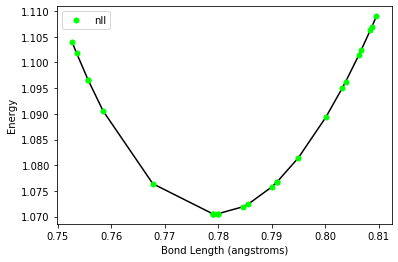

In [9]:
# Plotting energy vs bond length
plot_custom = False; plot_nll = True
distance_ordering = np.argsort(test_dist)
dists = test_dist[distance_ordering]
rescaled_test_ens = ens_scaler.inverse_transform(test_ens[distance_ordering], copy=True)
plt.plot(dists, rescaled_test_ens, c='k')
if plot_custom:
    rescaled_predict_ens_custom = ens_scaler.inverse_transform(predict_ens_custom.numpy()[distance_ordering], copy=True)
    plt.plot(dists, rescaled_predict_ens_custom, "o", label="custom", c="violet", ms=10)
if plot_nll:
    rescaled_predict_ens_nll =  ens_scaler.inverse_transform(predict_ens_nll.numpy()[distance_ordering], copy=True)
    plt.plot(dists, rescaled_predict_ens_nll, "o", label="nll", c="lime", ms=5)
plt.xlabel("Bond Length (angstroms)")
plt.ylabel("Energy")
plt.legend()

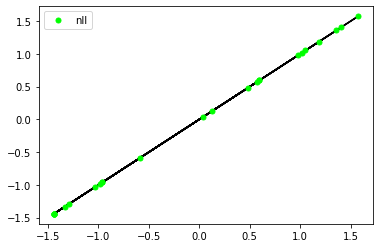

In [10]:
plt.plot(test_ens, test_ens, "-", c="k")
if plot_custom:
    plt.plot(test_ens, predict_ens_custom,"o", label="custom", c="violet", ms=10)
if plot_nll:
    plt.plot(test_ens, predict_ens_nll,"o", label="nll", c="lime", ms=5)
plt.legend()

F = -dE/dx = dE/ds ds/dx = dE'/ds' ds'/dx

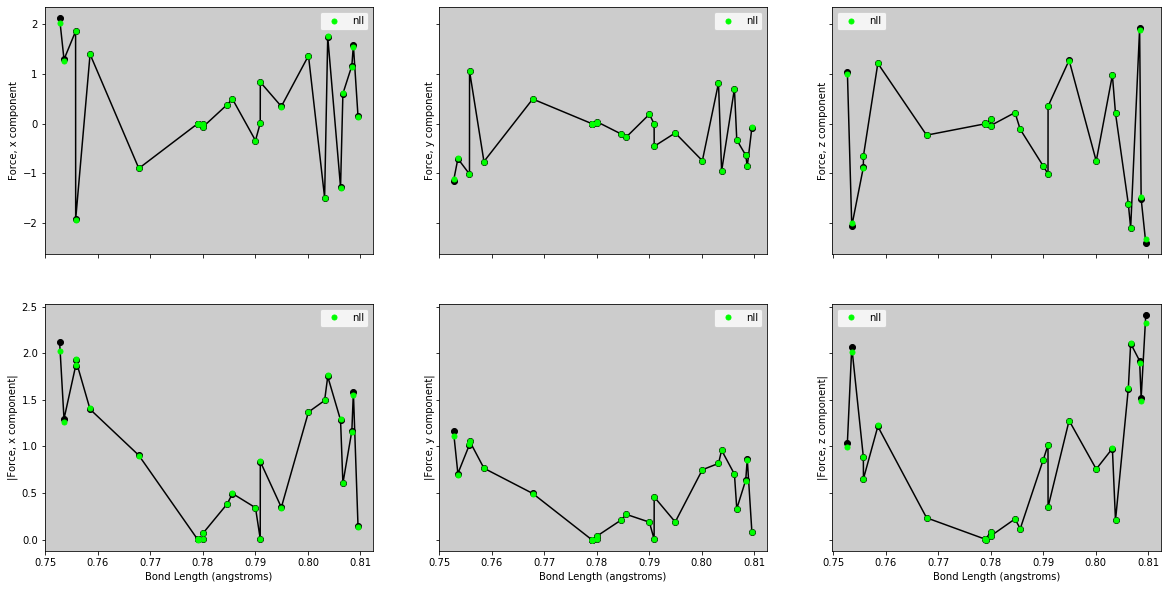

In [11]:
# Plotting force vs bond length
rescaled_test_frcs = test_frcs[distance_ordering] * ens_scaler.scale_
if plot_custom:
    rescaled_predict_frcs_custom =  predict_frcs_custom[distance_ordering] * ens_scaler.scale_
if plot_nll:
    rescaled_predict_frcs_nll = predict_frcs_nll[distance_ordering] * ens_scaler.scale_

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20,10), sharex='all', sharey='row')
axs = axs.flatten()

components = ["x", "y", "z"]

for i in range(3):
    axs[i].plot(dists, rescaled_test_frcs[:,0,i], "o-", c='k')
    axs[i+3].plot(dists, abs(rescaled_test_frcs[:,0,i]), "o-",  c='k') 
    
    if plot_custom:
        axs[i].plot(dists, rescaled_predict_frcs_custom[:,0,i], "o", label="custom", c="violet",ms=10)
        axs[i+3].plot(dists, abs(rescaled_predict_frcs_custom[:,0,i]), "o", label="custom", c="violet",ms=10)
        
    if plot_nll:
        axs[i].plot(dists, rescaled_predict_frcs_nll[:,0,i], "o", label="nll", c="lime", ms=5)
        axs[i+3].plot(dists, abs(rescaled_predict_frcs_nll[:,0,i]), "o", label="nll", c="lime", ms=5)

    axs[i].set_facecolor([.8]*3)
    axs[i].legend()
    axs[i].set_ylabel("Force, {} component".format(components[i]))
    
    axs[i+3].set_facecolor([.8]*3)
    axs[i+3].legend()
    axs[i+3].set_ylabel("|Force, {} component|".format(components[i]))    
    axs[i+3].set_xlabel("Bond Length (angstroms)")

Least-squares regresion for Fx(x) produces the line line m x+b with m = 0.99413 and b = -0.00457 which has r2 = 0.99981 
Least-squares regresion for Fy(y) produces the line line m y+b with m = 0.99413 and b = 0.00251 which has r2 = 0.99981 
Least-squares regresion for Fz(z) produces the line line m z+b with m = 0.98695 and b = -0.00017 which has r2 = 0.99983 


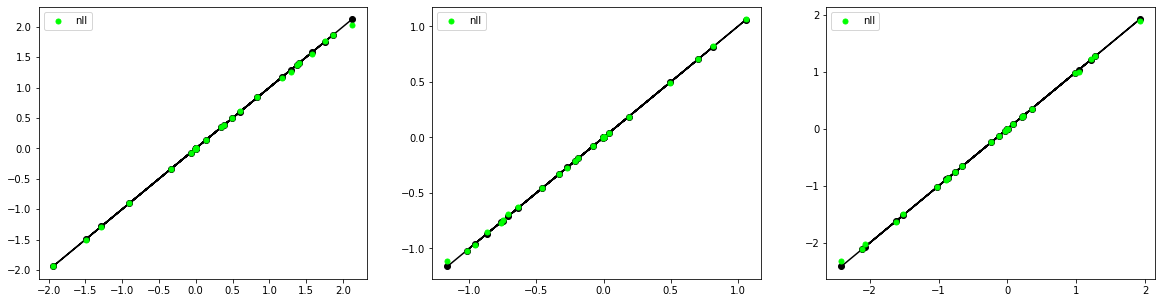

In [12]:
fig, axs = plt.subplots(ncols=3, figsize=(20,5))
components = ["x", "y", "z"]

for i in range(3):
    axs[i].plot(rescaled_test_frcs[:,0,i], rescaled_test_frcs[:,0,i], "o-", c="k")
    if plot_custom:
        axs[i].plot(rescaled_test_frcs[:,0,i], rescaled_predict_frcs_custom[:,0,i], "o", label="custom", c="violet", ms=10)
    if plot_nll:
        axs[i].plot(rescaled_test_frcs[:,0,i], rescaled_predict_frcs_nll[:,0,i], "o", label="nll", c="lime", ms=5)
        try:
            m, b = np.polyfit(rescaled_test_frcs[:,0,i], rescaled_predict_frcs_nll[:,0,i], 1)
            r2 = np.corrcoef(rescaled_test_frcs[:,0,i], rescaled_predict_frcs_nll[:,0,i])[0,1]
            print("Least-squares regresion for F{}({}) produces the line line m {}+b with m = {:.5f} and b = {:.5f} which has r2 = {:.5f} ".format(components[i],components[i],components[i],m,b, r2))
        except:
            pass        
    axs[i].legend()

---

### The above is for diatomics. The below is general


from unsynced

In [371]:
" ".join([str(n) for n in np.sort(list(performance_Graphene_by_n.keys()))])

'30 50 60 90 100 150 200 225 250 275 300 325 350 375 400 425 450 475 500 525 550 575 600 625 675 700 725 750 775 800 825 900 950 1000 1100 1200 1300 1500 1750 2000'

In [378]:
# Testing this with the C7O2H10 database (which contains 6095 structures)

my_n = ""
my_element="O"
my_temp=300
my_n_train = 10000
my_n_test = 30
my_n = my_n_train + my_n_test
my_calc = "EMT"
my_md_seed = 1

#AtomsList = read("../data/distorted_propanol.extxyz.gz", f":{my_n}")
AtomsList = read("../data/ManyGraphenes_unzipped.extxyz", f":{my_n}")
#AtomsList = generate_md_traj(from_diatomic=True, element=my_element, temperature=my_temp, nsteps=my_n, md_type = "VelocityVerlet", calc_type=my_calc, md_seed= my_md_seed)
EnergyList = np.array([atom.get_potential_energy() for atom in AtomsList], dtype=np.float64)
# EnergyList = np.array([atom.info["energy"] for atom in AtomsList], dtype=np.float64) # I had to change this to potential energy or the derivative doesn't work
PosList =  np.array([atoms.positions for atoms in AtomsList])#[:,1]# only get position of one atom while we are doing global soap
#SoapDerivativeList, SoapList = get_dscribe_descriptors(AtomsList, species=["C", "H", "O"], is_global=False, return_derivatives=True, nmax=5,lmax=5, is_periodic=True)
SoapList = get_dscribe_descriptors(AtomsList, species=np.unique(AtomsList[0].get_chemical_symbols()), is_global=False, return_derivatives=False, nmax=5,lmax=5, is_periodic=True)

# set

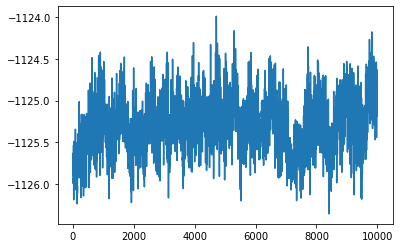

In [379]:
plt.plot(EnergyList)

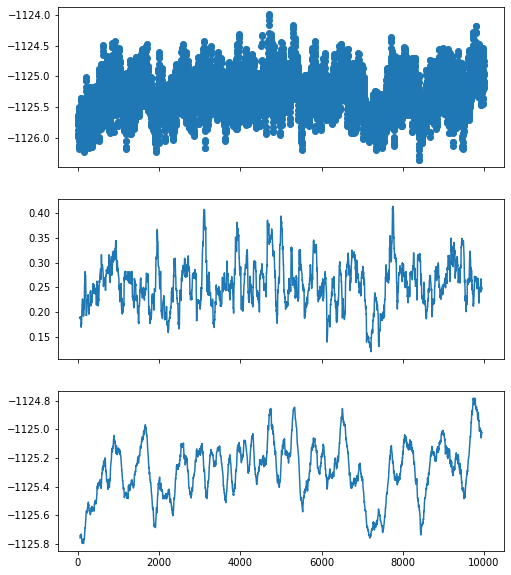

In [387]:
window = 100
rolling_stdevs = [np.std(EnergyList[i:i+window]) for i in range(len(EnergyList)-window+1)]
rolling_means = [np.mean(EnergyList[i:i+window]) for i in range(len(EnergyList)-window+1)]

fig, axs = plt.subplots(nrows=3, sharex =True, figsize=(8,10))

axs[0].plot(range(len(EnergyList)), EnergyList, "o")
axs[1].plot(np.arange(len(EnergyList)-window+1)+ (1 + window)/2, rolling_stdevs)
axs[2].plot(np.arange(len(EnergyList)-window+1)+ (1 + window)/2, rolling_means)

In [380]:
# This is my attempt at learning forces 
# Doesn't use LearnEnergyFromSoap because force learning is not yet implemented there (as of July 13th)
from sklearn.preprocessing import StandardScaler

collapsable=True

split_seed = 1
valid_split_seed = 1
training_frac = my_n_train/my_n#0.9
valid_fract = 0.9

train_sps, test_sps, train_ens, test_ens,  train_pos, test_pos = train_test_split(SoapList, EnergyList, PosList,  random_state=split_seed, test_size=(1-training_frac))

# scaling
# ----------------------------------------------------------------------------------------
if collapsable:
    # Standardize input for improved learning. Fit is done only on training data, scaling is applied to 
    # both descriptors and their derivatives on training and test sets.
    # # pass with_mean=False to avoid breaking sparsity structure of data
    rescale_method = 1
    if rescale_method == 1:
        train_sps, test_sps = train_sps.reshape(-1, SoapList.shape[-1]), test_sps.reshape(-1, SoapList.shape[-1])
        soap_scaler = StandardScaler().fit(train_sps)
        train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
        train_sps, test_sps = train_sps.reshape(-1, *SoapList.shape[1:]), test_sps.reshape(-1, *SoapList.shape[1:])
    elif rescale_method == 2:
        train_sps, test_sps = train_sps.reshape(train_sps.shape[0], -1), test_sps.reshape(test_sps.shape[0], -1)
        soap_scaler = StandardScaler().fit(train_sps)
        train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
        train_sps, test_sps = train_sps.reshape(len(train_ens), SoapList.shape[1], -1), test_sps.reshape(len(test_ens), SoapList.shape[1], -1)

    # rescale energies
    ens_scaler = StandardScaler().fit(train_ens[:,None])
    train_ens, test_ens = ens_scaler.transform(train_ens[:,None])[:,0], ens_scaler.transform(test_ens[:,None])[:,0]
# ----------------------------------------------------------------------------------------

observation_index_points= tf.constant(train_sps, dtype=np.float64)
ens_observations = tf.constant(train_ens, dtype=np.float64)
index_points = tf.constant(test_sps, dtype=np.float64)
#
shuffle_seed = 1
batch_size = 3
batch_size_custom_mse_max = 100
learn_rate = 0.025
n_epochs = 10; n_epochs_nll = n_epochs; n_epochs_custom = n_epochs
iterations_per_epoch = int(len(train_ens)/batch_size)
#


# initialize kernels and model hyperparameters
# ----------------------------------------------------------------------------------------
if collapsable:
    noise_init = 1e-5; amp_init = 0.1; len_init = 100#42
    constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
    # nll (old approach)
    obs_noise_nll = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_nll")
    amplitude_nll = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_nll")
    len_scale_nll = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_nll")
    kernel_nll = tfk.ExponentiatedQuadratic(amplitude=amplitude_nll, length_scale=len_scale_nll, name="kernel_nll", feature_ndims=2)#SoapList.shape[1])
    trainable_variables_nll = [var.variables[0] for var in [amplitude_nll, len_scale_nll, obs_noise_nll]]
    # mostly mse, my custom approach
    # allows for forces to be considered during training
    obs_noise_custom = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_custom")
    amplitude_custom = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_custom")
    len_scale_custom = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_custom")
    kernel_custom = tfk.ExponentiatedQuadratic(amplitude=amplitude_custom, length_scale=len_scale_custom, name="kernel_custom", feature_ndims=2)#SoapList.shape[1])
    trainable_variables_custom = [var.variables[0] for var in [amplitude_custom, len_scale_custom, obs_noise_custom]]
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# old/nll approach
# ----------------------------------------------------------------------------------------
if False:
    @tf.function(autograph=False, experimental_compile=False)
    def loss_nll(index_points, observations):
        gp = tfd.GaussianProcess(kernel=kernel_nll, index_points=index_points, observation_noise_variance=obs_noise_nll)

        return -gp.log_prob(observations)

    # Define mini-batch data iterator
    batches_nll = (
        tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations))
        .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )
    #

    optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)

    for j in range(n_epochs):
        if not j % 3:
            print("Old learning, epoch {}".format(j))

        for i, (index_points_i, ens_observations_i) in enumerate(islice(batches_nll, iterations_per_epoch)):
            with tf.GradientTape() as tape:
                loss_nll_i = loss_nll(index_points_i, ens_observations_i)
                loss_nll_i = tf.constant(loss_nll_i, dtype=np.float64)
            grads = tape.gradient(loss_nll_i, trainable_variables_nll)
            optimizer.apply_gradients(zip(grads, trainable_variables_nll))

    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    
        gprm_nll = tfd.GaussianProcessRegressionModel(
            kernel=kernel_nll,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_nll)
        predict_ens_nll = gprm_nll.mean()
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# custom/mostly mse approach
# ----------------------------------------------------------------------------------------
if collapsable:
    @tf.function(autograph=False, experimental_compile=False)
    def loss_custom_nll(index_points, observations):
        gp = tfd.GaussianProcess(kernel=kernel_custom, index_points=index_points, observation_noise_variance=obs_noise_custom)
        return -gp.log_prob(observations)

    @tf.function(autograph=False, experimental_compile=False)
    def mse(y_predict, y_true):
        return tf.math.reduce_mean(tf.math.squared_difference(y_predict, y_true))

    #@tf.function(autograph=False, experimental_compile=False)
    def mse_2factor(y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
        mse1 = mse(y1_predict, y1_true)
#         print("mse1 = ", mse1)
        mse2 = mse(y2_predict, y2_true)
#         print("mse2 = ", mse2)
        return mse1 * weight1 + mse2 * weight2

    # batch it
    batches_custom = (
        tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations))
        .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )

    optimizer_custom = tf.keras.optimizers.Adam(learning_rate=learn_rate)

    # First run through the data a few times, minimizing nll because this is more robust to bad hyperparameter initialization
    n_epochs_custom_nll = 0
    for j in range(n_epochs_custom_nll):
        for i, (index_points_i, ens_observations_i) in enumerate(islice(batches_custom, iterations_per_epoch)):
                with tf.GradientTape() as tape:
                    loss_custom_i = loss_custom_nll(index_points_i, ens_observations_i)
                    loss_custom_i = tf.constant(loss_custom_i, dtype=np.float64)
                grads = tape.gradient(loss_custom_i, trainable_variables_custom)
                optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))
    
    error_history = []
    for j in range(n_epochs_custom):
        if not j % 5:
            print("Custom learning, epoch {}".format(j))

        split_data_j = train_test_split(train_sps, train_ens, random_state =valid_split_seed+j, test_size=(1-valid_fract))
        train_sps_j, valid_sps_j, train_ens_j, valid_ens_j = split_data_j
        observation_index_points_j = tf.constant(train_sps_j, dtype=np.float64)
        ens_observations_j = tf.constant(train_ens_j, dtype=np.float64)
        heldout_index_points_j = tf.constant(valid_sps_j, dtype=np.float64)
        heldout_ens_observations_j = tf.constant(valid_ens_j, dtype=np.float64)


        if len(train_sps_j) < batch_size_custom_mse_max:
            iterations_per_epoch_custom = 1
            batch_size_custom = len(train_sps_j)
        else:
            iterations_per_epoch_custom = int(np.ceil(len(train_sps_j)/batch_size_custom_mse_max))
            batch_size_custom = int(np.ceil(len(train_sps_j)/iterations_per_epoch_custom))

        batches_custom_j = (
            tf.data.Dataset.from_tensor_slices((observation_index_points_j, ens_observations_j)) # frcs_observations_j_i might be extraneous
            .shuffle(buffer_size=len(observation_index_points_j), seed=shuffle_seed) # Should I modify this to be seed = shuffle_seed + j or does it not matter?
            .repeat(count=None)
            .batch(batch_size_custom)
        )
        error_j = 0
        for i, (index_points_j_i, ens_observations_j_i) in enumerate(islice(batches_custom_j, iterations_per_epoch_custom)):
            with tf.GradientTape() as tape:
                with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
                    tape_d_ens.watch(heldout_index_points_j)    
                    gprm_custom_j_i = tfd.GaussianProcessRegressionModel(
                        kernel = kernel_custom,
                        index_points = heldout_index_points_j,
                        observation_index_points = index_points_j_i,
                        observations = ens_observations_j_i,
                        observation_noise_variance = obs_noise_custom)
                    predict_ens_j_i = gprm_custom_j_i.sample()
                error_custom_j_i = mse(predict_ens_j_i, heldout_ens_observations_j)
                error_j += error_custom_j_i


            grads = tape.gradient(error_custom_j_i, trainable_variables_custom)
            optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))
        interpretable_error_j = np.sqrt(error_j/iterations_per_epoch_custom)
        error_history.append(interpretable_error_j)
        print("Error {} = {:.2f}".format(j, interpretable_error_j))


    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    

        gprm_custom = tfd.GaussianProcessRegressionModel(
            kernel=kernel_custom,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_custom)

        predict_ens_custom = gprm_custom.mean()
        
    performance_Graphene_by_n[my_n_train] = np.max(np.abs(ens_scaler.inverse_transform(test_ens) - ens_scaler.inverse_transform(predict_ens_custom)))
# ----------------------------------------------------------------------------------------


Custom learning, epoch 0
Error 0 = 0.95
Error 1 = 0.95
Error 2 = 0.97
Error 3 = 1.00
Error 4 = 0.97
Custom learning, epoch 5
Error 5 = 0.95
Error 6 = 0.95
Error 7 = 0.96
Error 8 = 0.94
Error 9 = 0.95


In [262]:
#performance_Graphene_by_n = {}

In [372]:
performance_Graphene_by_n

{30: 0.039455924021694955,
 50: 0.025520192534258967,
 60: 0.05015260878803929,
 90: 0.02628695509292811,
 100: 0.012542909998046525,
 200: 0.016431664258334422,
 300: 0.010318825536614895,
 500: 0.007422881928278002,
 150: 0.016834547242751796,
 900: 0.01562840400129062,
 700: 0.011335636350395362,
 250: 0.012518518815113566,
 1200: 0.012184416445052193,
 1000: 0.017007521724281105,
 1500: 0.015366629510708663,
 1100: 0.009441366010833008,
 400: 0.010275217199023245,
 600: 0.011123969460413718,
 800: 0.010949366652766912,
 2000: 0.019939079705636686,
 225: 0.006798546424988672,
 275: 0.010863128772143682,
 325: 0.007438278799327236,
 350: 0.01214594757220766,
 375: 0.012026006968198999,
 425: 0.00861313098721439,
 450: 0.015816443732319385,
 475: 0.019517097873631428,
 525: 0.007056522666516685,
 550: 0.012612630380317569,
 575: 0.011025575577605196,
 625: 0.013882095822964402,
 675: 0.009054737313363148,
 725: 0.014970176715223715,
 750: 0.012289034279092448,
 775: 0.0148924661887122

In [391]:
print(len(train_ens))

9970


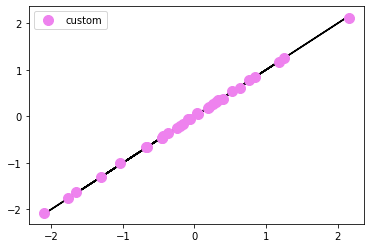

In [374]:
plot_custom = True; plot_nll = False
plt.plot(test_ens, test_ens, "-", c="k")
if plot_custom:
    plt.plot(test_ens, predict_ens_custom,"o", label="custom", c="violet", ms=10)
if plot_nll:
    plt.plot(test_ens, predict_ens_nll,"o", label="nll", c="lime", ms=5)
plt.legend()

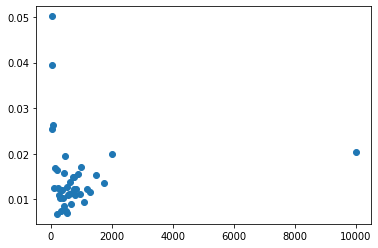

In [388]:
plt.plot(list(performance_Graphene_by_n.keys()), list(performance_Graphene_by_n.values()), "o")

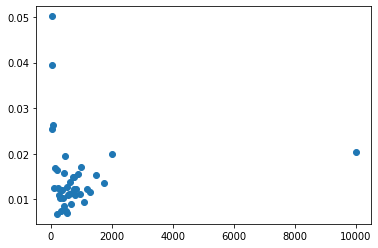

In [389]:
# delete above cell when this loads (this is an updated version)
plt.plot(list(performance_Graphene_by_n.keys()), list(performance_Graphene_by_n.values()), "o")

In [252]:
ens_scaler.scale_
ens_scaler.inverse_transform(predict_ens_custom)

array([-1125.72447817, -1125.83888506, -1125.88402636, -1125.89747451,
       -1125.74671946, -1125.65953381, -1125.83022568, -1125.55344613,
       -1125.91280785, -1125.92123884, -1125.56958975, -1125.67603525,
       -1125.70005333, -1125.79199962, -1125.93484373, -1125.62953911,
       -1125.89950445, -1125.77674277, -1125.79498986, -1125.62464417,
       -1125.59673363, -1125.73943533, -1125.82916842, -1125.66056373,
       -1125.70188755, -1125.85798284, -1125.93615262, -1126.0709101 ,
       -1125.72963819, -1125.52382698])

In [104]:
# Collect input data for soap->energy/forces learning model without looping
# Unlike above (in the Plottable_Model_Errors cell) I am collecting forces here as well

# MD parameters
my_temp=300
my_n = 500
my_calc = "EMT"
my_md_seed = 1

# SOAP parameters
get_local_descriptors = True
my_nmax=1
my_lmax=1


#AtomsList = read("../data/ManyGraphenes.gz", ":{}".format(my_n))
AtomsList = read("../data/distorted_propanol.extxyz.gz", ":{}".format(my_n))
PosList =  np.array([atoms.positions for atoms in AtomsList])#[:,1]# only get position of one atom while we are doing global soap

EnergyList = np.array([atom.get_potential_energy() for atom in AtomsList], dtype=np.float64) # I had to change this to potential energy or the derivative doesn't work
ForceList = np.array([atom.get_forces() for atom in AtomsList], dtype=np.float64)#[:,1] # only get force of one atom while we are doing global soap
SoapDerivativeList, SoapList = get_dscribe_descriptors(AtomsList, species=np.unique(AtomsList[0].get_chemical_symbols()), is_global= not get_local_descriptors, return_derivatives=True, nmax=my_nmax, lmax=my_lmax)
#SoapDerivativeList = SoapDerivativeList[:,0,:,:,:]; SoapList = SoapList[:,0,:] # Using global soap right now so we can remove the local descriptor index
SoapList = SoapList[:,0,:] 
#SoapList = SoapList.reshape(len(SoapList),-1)

In [116]:
# This is my attempt at learning forces 
# Doesn't use LearnEnergyFromSoap because force learning is not yet implemented there (as of July 13th)

split_seed = 1
valid_split_seed = 1
training_frac = 0.9
valid_fract = 0.9

split_data = train_test_split(SoapList, SoapDerivativeList, EnergyList, ForceList, PosList, range(len(SoapList)), 
                              random_state=split_seed, test_size=(1-training_frac))
train_sps, test_sps, train_d_sps, test_d_sps, train_ens, test_ens, train_frcs, test_frcs, train_pos, test_pos, train_indices, test_indices = split_data

# scaling
# Standardize input for improved learning. Fit is done only on training data, scaling is applied to 
# both descriptors and their derivatives on training and test sets.
# # pass with_mean=False to avoid breaking sparsity structure of data
# soap_scaler = StandardScaler().fit(train_sps.reshape(-1,train_sps.shape[-1]))
# train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
# train_d_sps = train_d_sps / soap_scaler.scale_[None, None, None, :]
# test_d_sps = test_d_sps / soap_scaler.scale_[None, None, None, :]

# # Should I also rescale energies and/or forces?
# # For now I will
# ens_scaler = StandardScaler().fit(train_ens)
# train_ens, test_ens = ens_scaler.transform(train_ens), ens_scaler.transform(test_ens)
# train_frcs = train_frcs / ens_scaler.scale_#[None, :, None]
# test_frcs = test_frcs / ens_scaler.scale_#[None, :, None]

ens_scaler = StandardScaler().fit(train_ens[:,None])
train_ens, test_ens = ens_scaler.transform(train_ens[:,None])[:,0], ens_scaler.transform(test_ens[:,None])[:,0]
train_frcs = train_frcs / ens_scaler.scale_#[None, :, None]
test_frcs = test_frcs / ens_scaler.scale_#[None, :, None]

# # Should the variance be calculated before the rescaling?
ens_var = train_ens.var(); frcs_var = train_frcs.var()

#observation_index_points= tf.constant(np.array(train_pos), dtype=np.float64)
observation_index_points= tf.constant(train_sps, dtype=np.float64)
ens_observations = tf.constant(train_ens, dtype=np.float64)
frcs_observations = tf.constant(train_frcs, dtype=np.float64)
#index_points = tf.constant(np.array(test_pos), dtype=np.float64)
index_points = tf.constant(test_sps, dtype=np.float64)
#
shuffle_seed = 1
batch_size = 3
batch_size_custom_mse_max = 100
learn_rate = 0.05
n_epochs = 20; n_epochs_nll = n_epochs; n_epochs_custom = n_epochs
iterations_per_epoch = int(len(train_ens)/batch_size)
#


# initialize kernels and model hyperparameters
# ----------------------------------------------------------------------------------------
noise_init = 1e-1; amp_init = .1; len_init = 100
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
# nll (old approach)
obs_noise_nll = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_nll")
amplitude_nll = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_nll")
len_scale_nll = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_nll")
kernel_nll = tfk.ExponentiatedQuadratic(amplitude=amplitude_nll, length_scale=len_scale_nll, name="kernel_nll", feature_ndims=1)#SoapList.shape[1])
trainable_variables_nll = [var.variables[0] for var in [amplitude_nll, len_scale_nll, obs_noise_nll]]
# mostly mse, my custom approach
# allows for forces to be considered during training
obs_noise_custom = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_custom")
amplitude_custom = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_custom")
len_scale_custom = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_custom")
kernel_custom = tfk.ExponentiatedQuadratic(amplitude=amplitude_custom, length_scale=len_scale_custom, name="kernel_custom", feature_ndims=SoapList.shape[1])
trainable_variables_custom = [var.variables[0] for var in [amplitude_custom, len_scale_custom, obs_noise_custom]]
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# old/nll approach
# ----------------------------------------------------------------------------------------
@tf.function(autograph=False, experimental_compile=False)
def loss_nll(index_points, observations):
    gp = tfd.GaussianProcess(kernel=kernel_nll, index_points=index_points, observation_noise_variance=obs_noise_nll)
    print("index_points.shape = ", index_points.shape)
    print("observations.shape = ", observations.shape)
    return -gp.log_prob(observations)

# Define mini-batch data iterator
batches_nll = (
    tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations))
    .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
    .repeat(count=None)
    .batch(batch_size)
)
#

optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)

if False:
    for j in range(n_epochs):

        loss_nll_j = 0
        for i, (index_points_i, ens_observations_i) in enumerate(islice(batches_nll, iterations_per_epoch)):
            with tf.GradientTape() as tape:
                loss_nll_i = loss_nll(index_points_i, ens_observations_i)
                loss_nll_i = tf.constant(loss_nll_i, dtype=np.float64)
                loss_nll_j += loss_nll_i
            grads = tape.gradient(loss_nll_i, trainable_variables_nll)
            optimizer.apply_gradients(zip(grads, trainable_variables_nll))
        if not j % 4:
            print("Old learning, epoch {} loss: {:10.0f}".format(j, loss_nll_j))
            print([(v.name, 2.71828**v.numpy()) for v in trainable_variables_nll])

    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    
        gprm_nll = tfd.GaussianProcessRegressionModel(
            kernel=kernel_nll,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_nll)
        print(index_points.shape)
        print(observation_index_points.shape)
        print(ens_observations.shape)
        predict_ens_nll = gprm_nll.mean()

    predict_d_ens_nll = tape_d_ens.gradient(predict_ens_nll, index_points)
    #print(predict_d_ens_nll[:1])
    #predict_d_ens_nll = predict_d_ens_nll[:,0,:]
    #print(predict_d_ens_nll[:1])

    print("predict_d_ens_nll.shape =", predict_d_ens_nll.shape)
    print("test_d_sps.shape = ", test_d_sps.shape )
    print("\ntest_d_sps[0][:,:,0] = \n", test_d_sps[0][:,:,0])
    print("\npredict_d_ens_nll[0] = \n", predict_d_ens_nll[0])
    predict_frcs_nll = -1*np.einsum('imjkl,il->ijk', test_d_sps, predict_d_ens_nll)#[:,1] # only get force of one atom while we are doing global soap
    print("\npredict_frcs_nll[0][:,0] = \n", predict_frcs_nll[0][:,0])

    # predict_d_ens_nll.shape = (75, 2, 18)
    # test_d_sps.shape =  (75, 2, 2, 3, 18)
    #     print("test_d_sps", test_d_sps)
    #     print("predict_d_ens_nll", predict_d_ens_nll)
    #     print("predict_frcs_nll", -1*np.einsum('ijkl,il->ijk', test_d_sps, predict_d_ens_nll))
    # ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# custom/mostly mse approach
# ----------------------------------------------------------------------------------------
if True:
    @tf.function(autograph=False, experimental_compile=False)
    def loss_custom_nll(index_points, observations):
        gp = tfd.GaussianProcess(kernel=kernel_custom, index_points=index_points, observation_noise_variance=obs_noise_custom)
        return -gp.log_prob(observations)

    @tf.function(autograph=False, experimental_compile=False)
    def mse(y_predict, y_true):
        return tf.math.reduce_mean(tf.math.squared_difference(y_predict, y_true))

    #@tf.function(autograph=False, experimental_compile=False)
    def mse_2factor(y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
        mse1 = mse(y1_predict, y1_true)
#         print("mse1 = ", mse1)
        mse2 = mse(y2_predict, y2_true)
#         print("mse2 = ", mse2)
        return mse1 * weight1 + mse2 * weight2

    # batch it
    batches_custom = (
        tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations, frcs_observations))
        .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )

    optimizer_custom = tf.keras.optimizers.Adam(learning_rate=learn_rate)

    # First run through the data a few times, minimizing nll because this is more robust to bad hyperparameter initialization
    n_epochs_custom_nll = 3
    for j in range(n_epochs_custom_nll):
        for i, (index_points_i, ens_observations_i, ignore_forces_here) in enumerate(islice(batches_custom, iterations_per_epoch)):
                with tf.GradientTape() as tape:
                    loss_custom_i = loss_custom_nll(index_points_i, ens_observations_i)
                    loss_custom_i = tf.constant(loss_custom_i, dtype=np.float64)
                grads = tape.gradient(loss_custom_i, trainable_variables_custom)
                optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))

    for j in range(n_epochs_custom):
        if not j % 10:
            print("Custom learning, epoch {}".format(j+1))

        split_data_j = train_test_split(train_sps, train_ens, train_d_sps, train_frcs, random_state =valid_split_seed+j, test_size=(1-valid_fract))
        train_sps_j, valid_sps_j, train_ens_j, valid_ens_j, train_d_sps_j, valid_d_sps_j, train_frcs_j, valid_frcs_j = split_data_j
        observation_index_points_j = tf.constant(train_sps_j, dtype=np.float64)
        ens_observations_j = tf.constant(train_ens_j, dtype=np.float64)
        d_sps_observations_j = tf.constant(train_d_sps_j, dtype=np.float64)
        frcs_observations_j = tf.constant(train_frcs_j, dtype=np.float64)
        heldout_index_points_j = tf.constant(valid_sps_j, dtype=np.float64)
        heldout_ens_observations_j = tf.constant(valid_ens_j, dtype=np.float64)
        heldout_d_sps_observations_j = tf.constant(valid_d_sps_j, dtype=np.float64)
        heldout_frcs_observations_j = tf.constant(valid_frcs_j, dtype=np.float64)

        if len(train_sps_j) < batch_size_custom_mse_max:
            iterations_per_epoch_custom = 1
            batch_size_custom = len(train_sps_j)
        else:
            iterations_per_epoch_custom = int(np.ceil(len(train_sps_j)/batch_size_custom_mse_max))
            batch_size_custom = int(np.ceil(len(train_sps_j)/iterations_per_epoch_custom))

        batches_custom_j = (
            tf.data.Dataset.from_tensor_slices((observation_index_points_j, ens_observations_j, d_sps_observations_j, frcs_observations_j)) # frcs_observations_j_i might be extraneous
            .shuffle(buffer_size=len(observation_index_points_j), seed=shuffle_seed) # Should I modify this to be seed = shuffle_seed + j or does it not matter?
            .repeat(count=None)
            .batch(batch_size_custom)
        )
        for i, (index_points_j_i, ens_observations_j_i, d_sps_observations_j_i, frcs_observations_j_i) \
                in enumerate(islice(batches_custom_j, iterations_per_epoch_custom)):
            with tf.GradientTape() as tape:
                with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
                    tape_d_ens.watch(heldout_index_points_j)    
                    gprm_custom_j_i = tfd.GaussianProcessRegressionModel(
                        kernel = kernel_custom,
                        index_points = heldout_index_points_j,
                        observation_index_points = index_points_j_i,
                        observations = ens_observations_j_i,
                        observation_noise_variance = obs_noise_custom)
                    predict_ens_j_i = gprm_custom_j_i.sample()
                predict_d_ens_j_i = tape_d_ens.gradient(predict_ens_j_i, heldout_index_points_j)
                #predict_frcs_j_i = -predict_d_ens_j_i
                predict_frcs_j_i = -1*np.einsum('imjkl,il->ijk', heldout_d_sps_observations_j, predict_d_ens_j_i)#[:,1] # only get force of one atom while we are doing global soap
                error_custom_j_i = mse_2factor(predict_ens_j_i, heldout_ens_observations_j, 1/ens_var,
                                               predict_frcs_j_i, heldout_frcs_observations_j, 1/frcs_var)
#                 print("predict_ens_j_i = ", predict_ens_j_i)
#                 print("heldout_ens_observations_j = ", heldout_ens_observations_j)
#                 print("1/ens_var = ", 1/ens_var)
#                 print("predict_frcs_j_i = ", predict_frcs_j_i)
#                 print("heldout_frcs_observations_j = ", heldout_frcs_observations_j)
#                 print("1/frcs_var = ",1/frcs_var)
#                 print("error value is ", error_custom_j_i)

            grads = tape.gradient(error_custom_j_i, trainable_variables_custom)
            optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))


    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    

        gprm_custom = tfd.GaussianProcessRegressionModel(
            kernel=kernel_custom,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_custom)

        predict_ens_custom = gprm_custom.mean()

    predict_d_ens_custom = tape_d_ens.gradient(predict_ens_custom, index_points)
    #predict_frcs_custom = -predict_d_ens_custom.numpy()
    predict_frcs_custom = -1*np.einsum('imjkl,il->ijk', test_d_sps, predict_d_ens_custom)#[:,1] # only get force of one atom while we are doing global soap
# -------------------------------------------------------------------



ValueError: Found input variables with inconsistent numbers of samples: [200, 200, 200, 500, 200, 200]

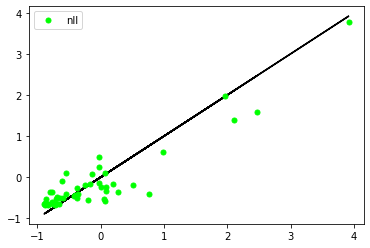

In [106]:
plot_custom = False; plot_nll = True
plt.plot(test_ens, test_ens, "-", c="k")
if plot_custom:
    plt.plot(test_ens, predict_ens_custom,"o", label="custom", c="violet", ms=10)
if plot_nll:
    plt.plot(test_ens, predict_ens_nll,"o", label="nll", c="lime", ms=5)
plt.legend()

Now with polynomial kernel

In [78]:
# This is my attempt at learning forces 
# Doesn't use LearnEnergyFromSoap because force learning is not yet implemented there (as of July 13th)

split_seed = 1
valid_split_seed = 1
training_frac = 0.9
valid_fract = 0.9

split_data = train_test_split(SoapList, SoapDerivativeList, EnergyList, ForceList, PosList, range(len(SoapList)), 
                              random_state=split_seed, test_size=(1-training_frac))
train_sps, test_sps, train_d_sps, test_d_sps, train_ens, test_ens, train_frcs, test_frcs, train_pos, test_pos, train_indices, test_indices = split_data

# scaling
# Standardize input for improved learning. Fit is done only on training data, scaling is applied to 
# both descriptors and their derivatives on training and test sets.
# # pass with_mean=False to avoid breaking sparsity structure of data
# soap_scaler = StandardScaler().fit(train_sps.reshape(-1,train_sps.shape[-1]))
# train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
# train_d_sps = train_d_sps / soap_scaler.scale_[None, None, None, :]
# test_d_sps = test_d_sps / soap_scaler.scale_[None, None, None, :]

# # Should I also rescale energies and/or forces?
# # For now I will
# ens_scaler = StandardScaler().fit(train_ens)
# train_ens, test_ens = ens_scaler.transform(train_ens), ens_scaler.transform(test_ens)
# train_frcs = train_frcs / ens_scaler.scale_#[None, :, None]
# test_frcs = test_frcs / ens_scaler.scale_#[None, :, None]

ens_scaler = StandardScaler().fit(train_ens[:,None])
train_ens, test_ens = ens_scaler.transform(train_ens[:,None])[:,0], ens_scaler.transform(test_ens[:,None])[:,0]
train_frcs = train_frcs / ens_scaler.scale_#[None, :, None]
test_frcs = test_frcs / ens_scaler.scale_#[None, :, None]

# # Should the variance be calculated before the rescaling?
ens_var = train_ens.var(); frcs_var = train_frcs.var()

#observation_index_points= tf.constant(np.array(train_pos), dtype=np.float64)
observation_index_points= tf.constant(train_sps, dtype=np.float64)
ens_observations = tf.constant(train_ens, dtype=np.float64)
frcs_observations = tf.constant(train_frcs, dtype=np.float64)
#index_points = tf.constant(np.array(test_pos), dtype=np.float64)
index_points = tf.constant(test_sps, dtype=np.float64)
#
shuffle_seed = 1
batch_size = 3
batch_size_custom_mse_max = 100
learn_rate = 0.05
n_epochs = 21; n_epochs_nll = n_epochs; n_epochs_custom = n_epochs
iterations_per_epoch = int(len(train_ens)/batch_size)
#


# initialize kernels and model hyperparameters
# ----------------------------------------------------------------------------------------
noise_init = 1e2; bias_var_init = 1e-10; slope_var_init=1e2
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
# nll (old approach)
exp_nll = tf.constant(2.0, dtype=np.float64)
bias_variance_nll = tfp.util.TransformedVariable(initial_value=bias_var_init, bijector=constrain_positive, dtype=np.float64, name="bias_var_nll")
slope_variance_nll = tfp.util.TransformedVariable(initial_value=slope_var_init, bijector=constrain_positive, dtype=np.float64, name="slope_var_nll")
obs_noise_nll = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_nll")
p_kernel_nll = tfk.Polynomial(exponent=exp_nll, slope_variance=slope_variance_nll, bias_variance=bias_variance_nll, name="p_kernel_nll", feature_ndims=1)#SoapList.shape[1])
trainable_variables_nll = [var.variables[0] for var in [ obs_noise_nll, bias_variance_nll, slope_variance_nll]]
# mostly mse, my custom approach
# allows for forces to be considered during training
obs_noise_custom = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_custom")
exp_custom = tf.constant(2.0, dtype=np.float64)
p_kernel_custom = tfk.Polynomial(exponent=exp_custom, name="p_kernel_custom", feature_ndims=1)#SoapList.shape[1])
trainable_variables_custom = [var.variables[0] for var in [obs_noise_custom]]
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# old/nll approach
# ----------------------------------------------------------------------------------------
#@tf.function(autograph=False, experimental_compile=False)
def loss_nll(index_points, observations):
    gp = tfd.GaussianProcess(kernel=p_kernel_nll, index_points=index_points, observation_noise_variance=obs_noise_nll)
    #print("index_points.shape = ", index_points.shape)
    #print("observations.shape = ", observations.shape)
    return -gp.log_prob(observations)

# Define mini-batch data iterator
batches_nll = (
    tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations))
    .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
    .repeat(count=None)
    .batch(batch_size)
)
#

optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)

for j in range(n_epochs):
    loss_nll_j = 0
    for i, (index_points_i, ens_observations_i) in enumerate(islice(batches_nll, iterations_per_epoch)):
        with tf.GradientTape() as tape:
            loss_nll_i = loss_nll(index_points_i, ens_observations_i)
            loss_nll_i = tf.constant(loss_nll_i, dtype=np.float64)
            loss_nll_j += loss_nll_i
        grads = tape.gradient(loss_nll_i, trainable_variables_nll)
        optimizer.apply_gradients(zip(grads, trainable_variables_nll))
    if not j % 10:
        print("Old learning, epoch {} loss: {:10.0f}".format(j, loss_nll_j))
        print(bias_variance_nll)
        print(slope_variance_nll)

with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
    tape_d_ens.watch(index_points)    
    gprm_nll = tfd.GaussianProcessRegressionModel(
        kernel=kernel_nll,
        index_points=index_points,
        observation_index_points=observation_index_points,
        observations=ens_observations,
        observation_noise_variance=obs_noise_nll)
    print(index_points.shape)
    print(observation_index_points.shape)
    print(ens_observations.shape)
    predict_ens_nll = gprm_nll.mean()

predict_d_ens_nll = tape_d_ens.gradient(predict_ens_nll, index_points)
#print(predict_d_ens_nll[:1])
#predict_d_ens_nll = predict_d_ens_nll[:,0,:]
#print(predict_d_ens_nll[:1])

print("predict_d_ens_nll.shape =", predict_d_ens_nll.shape)
print("test_d_sps.shape = ", test_d_sps.shape )
print("\ntest_d_sps[0][:,:,0] = \n", test_d_sps[0][:,:,0])
print("\npredict_d_ens_nll[0] = \n", predict_d_ens_nll[0])
predict_frcs_nll = -1*np.einsum('imjkl,il->ijk', test_d_sps, predict_d_ens_nll)#[:,1] # only get force of one atom while we are doing global soap
print("\npredict_frcs_nll[0][:,0] = \n", predict_frcs_nll[0][:,0])

# predict_d_ens_nll.shape = (75, 2, 18)
# test_d_sps.shape =  (75, 2, 2, 3, 18)
#     print("test_d_sps", test_d_sps)
#     print("predict_d_ens_nll", predict_d_ens_nll)
#     print("predict_frcs_nll", -1*np.einsum('ijkl,il->ijk', test_d_sps, predict_d_ens_nll))
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# custom/mostly mse approach
# ----------------------------------------------------------------------------------------
if False:
    @tf.function(autograph=False, experimental_compile=False)
    def loss_custom_nll(index_points, observations):
        gp = tfd.GaussianProcess(kernel=kernel_custom, index_points=index_points, observation_noise_variance=obs_noise_custom)
        return -gp.log_prob(observations)

    @tf.function(autograph=False, experimental_compile=False)
    def mse(y_predict, y_true):
        return tf.math.reduce_mean(tf.math.squared_difference(y_predict, y_true))

    #@tf.function(autograph=False, experimental_compile=False)
    def mse_2factor(y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
        mse1 = mse(y1_predict, y1_true)
#         print("mse1 = ", mse1)
        mse2 = mse(y2_predict, y2_true)
#         print("mse2 = ", mse2)
        return mse1 * weight1 + mse2 * weight2

    # batch it
    batches_custom = (
        tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations, frcs_observations))
        .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )

    optimizer_custom = tf.keras.optimizers.Adam(learning_rate=learn_rate)

    # First run through the data a few times, minimizing nll because this is more robust to bad hyperparameter initialization
    n_epochs_custom_nll = 3
    for j in range(n_epochs_custom_nll):
        for i, (index_points_i, ens_observations_i, ignore_forces_here) in enumerate(islice(batches_custom, iterations_per_epoch)):
                with tf.GradientTape() as tape:
                    loss_custom_i = loss_custom_nll(index_points_i, ens_observations_i)
                    loss_custom_i = tf.constant(loss_custom_i, dtype=np.float64)
                grads = tape.gradient(loss_custom_i, trainable_variables_custom)
                optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))

    for j in range(n_epochs_custom):
        if not j % 10:
            print("Custom learning, epoch {}".format(j+1))

        split_data_j = train_test_split(train_sps, train_ens, train_d_sps, train_frcs, random_state =valid_split_seed+j, test_size=(1-valid_fract))
        train_sps_j, valid_sps_j, train_ens_j, valid_ens_j, train_d_sps_j, valid_d_sps_j, train_frcs_j, valid_frcs_j = split_data_j
        observation_index_points_j = tf.constant(train_sps_j, dtype=np.float64)
        ens_observations_j = tf.constant(train_ens_j, dtype=np.float64)
        d_sps_observations_j = tf.constant(train_d_sps_j, dtype=np.float64)
        frcs_observations_j = tf.constant(train_frcs_j, dtype=np.float64)
        heldout_index_points_j = tf.constant(valid_sps_j, dtype=np.float64)
        heldout_ens_observations_j = tf.constant(valid_ens_j, dtype=np.float64)
        heldout_d_sps_observations_j = tf.constant(valid_d_sps_j, dtype=np.float64)
        heldout_frcs_observations_j = tf.constant(valid_frcs_j, dtype=np.float64)

        if len(train_sps_j) < batch_size_custom_mse_max:
            iterations_per_epoch_custom = 1
            batch_size_custom = len(train_sps_j)
        else:
            iterations_per_epoch_custom = int(np.ceil(len(train_sps_j)/batch_size_custom_mse_max))
            batch_size_custom = int(np.ceil(len(train_sps_j)/iterations_per_epoch_custom))

        batches_custom_j = (
            tf.data.Dataset.from_tensor_slices((observation_index_points_j, ens_observations_j, d_sps_observations_j, frcs_observations_j)) # frcs_observations_j_i might be extraneous
            .shuffle(buffer_size=len(observation_index_points_j), seed=shuffle_seed) # Should I modify this to be seed = shuffle_seed + j or does it not matter?
            .repeat(count=None)
            .batch(batch_size_custom)
        )
        for i, (index_points_j_i, ens_observations_j_i, d_sps_observations_j_i, frcs_observations_j_i) \
                in enumerate(islice(batches_custom_j, iterations_per_epoch_custom)):
            with tf.GradientTape() as tape:
                with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
                    tape_d_ens.watch(heldout_index_points_j)    
                    gprm_custom_j_i = tfd.GaussianProcessRegressionModel(
                        kernel = kernel_custom,
                        index_points = heldout_index_points_j,
                        observation_index_points = index_points_j_i,
                        observations = ens_observations_j_i,
                        observation_noise_variance = obs_noise_custom)
                    predict_ens_j_i = gprm_custom_j_i.sample()
                predict_d_ens_j_i = tape_d_ens.gradient(predict_ens_j_i, heldout_index_points_j)
                #predict_frcs_j_i = -predict_d_ens_j_i
                predict_frcs_j_i = -1*np.einsum('imjkl,il->ijk', heldout_d_sps_observations_j, predict_d_ens_j_i)#[:,1] # only get force of one atom while we are doing global soap
                error_custom_j_i = mse_2factor(predict_ens_j_i, heldout_ens_observations_j, 1/ens_var,
                                               predict_frcs_j_i, heldout_frcs_observations_j, 1/frcs_var)
#                 print("predict_ens_j_i = ", predict_ens_j_i)
#                 print("heldout_ens_observations_j = ", heldout_ens_observations_j)
#                 print("1/ens_var = ", 1/ens_var)
#                 print("predict_frcs_j_i = ", predict_frcs_j_i)
#                 print("heldout_frcs_observations_j = ", heldout_frcs_observations_j)
#                 print("1/frcs_var = ",1/frcs_var)
#                 print("error value is ", error_custom_j_i)

            grads = tape.gradient(error_custom_j_i, trainable_variables_custom)
            optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))


    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    

        gprm_custom = tfd.GaussianProcessRegressionModel(
            kernel=kernel_custom,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_custom)

        predict_ens_custom = gprm_custom.mean()

    predict_d_ens_custom = tape_d_ens.gradient(predict_ens_custom, index_points)
    #predict_frcs_custom = -predict_d_ens_custom.numpy()
    predict_frcs_custom = -1*np.einsum('imjkl,il->ijk', test_d_sps, predict_d_ens_custom)#[:,1] # only get force of one atom while we are doing global soap
# -------------------------------------------------------------------



Old learning, epoch 0 loss:       1036
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=9.999999999999996e-11>
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=5.264346569566937>
Old learning, epoch 10 loss:        257
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=9.999999999994347e-11>
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=0.0003167384302860716>
Old learning, epoch 20 loss:        256
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=9.999999999992962e-11>
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=0.00027292594941086983>
(20, 2)
(180, 2)
(180,)
predict_d_ens_nll.shape = (20, 2)
test_d_sps.shape =  (20, 112, 112, 3, 2)

test_d_sps[0][:,:,0] = 
 [[[ 0.0000000e+00  1.8211912e-01]
  [-1.1813260e+01 -2.8771907e-01]
  [-1.8961560e+00 -1.3441440e-01]
  ...
  [-1.6820769e-01 -7.498376

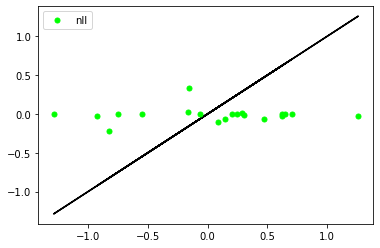

In [80]:
plot_custom = False; plot_nll = True
plt.plot(test_ens, test_ens, "-", c="k")
if plot_custom:
    plt.plot(test_ens, predict_ens_custom,"o", label="custom", c="violet", ms=10)
if plot_nll:
    plt.plot(test_ens, predict_ens_nll,"o", label="nll", c="lime", ms=5)
plt.legend()

In [57]:
noise_init = 1e-5; amp_init = 1; len_init = 3
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
# nll (old approach)
obs_noise_nll = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_nll")
amplitude_nll = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_nll")
len_scale_nll = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_nll")
kernel_nll = tfk.ExponentiatedQuadratic(amplitude=amplitude_nll, length_scale=len_scale_nll, name="kernel_nll", feature_ndims=2)

In [58]:
def loss_nll(index_points, observations):

    gp = tfd.GaussianProcess(kernel=kernel_nll, index_points=index_points, observation_noise_variance=obs_noise_nll)
    print("index_points.shape = ", index_points.shape)
    print("observations.shape = ", observations.shape)
    return -gp.log_prob(observations)

def gprm(obs_index_points, observations, index_points):
    print("batch_shape = ", kernel_nll.batch_shape)
    print("feature dimensions = ", kernel_nll.feature_ndims)
    print("obs_index_points.shape = ", obs_index_points.shape)    
    print("observations.shape = ", observations.shape)
    print("index_points.shape = ", index_points.shape)
    gprm_nll = tfd.GaussianProcessRegressionModel(
        kernel=kernel_nll,
        index_points=index_points,
        observation_index_points=obs_index_points,
        observations=observations,
        observation_noise_variance=obs_noise_nll)
    return gprm_nll.mean()

test_xs = tf.constant(rand.random(( 5,  2, 18)), dtype=np.float64)
xs = tf.constant(rand.random((3, 2, 18)), dtype=np.float64)
ys = rand.random(3)
#ys[0] = [300 for y in ys[0]]
ys = tf.constant(ys, dtype=np.float64)
PrintNoScientificNotation("predicitons = ", gprm(xs, ys,test_xs))
# This is not what we want
# The first (batch) dimension is only used to predict corresponding outputs

batch_shape =  ()
feature dimensions =  2
obs_index_points.shape =  (3, 2, 18)
observations.shape =  (3,)
index_points.shape =  (5, 2, 18)
predicitons =  tf.Tensor([0.38338199 0.58308328 0.43920567 0.54515858 0.59879727], shape=(5,), dtype=float64)


# Save as script 

The following cell will save this notebook as a python script

In [1]:
!jupyter nbconvert --to script miniGAP.ipynb --output latest_miniGAP

[NbConvertApp] Converting notebook miniGAP.ipynb to script
[NbConvertApp] Writing 69372 bytes to latest_miniGAP.py
